In [2]:
import os
import  matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import show_hist # Useful if you wish to plot all hist and GPS target image
from rasterio.mask import mask
from shapely.geometry.point import Point
import shapely
import numpy as np
import csv
import fiona
from tools_AA_IR import reading_gps_file, circle_sensor, plottingtemp_single_label_IR
from tools_AA_IR import path_IR, get_tif,get_value_IR
from tools_AA_IR import circle_to_shape, readingIR , IR_mask, readingIR_all
from tools_AA import readingtemp_AA, slice_raw, path_sonde, name_sonde, plottingtemp_single_label
from tools_EL import readingtemp, plottingtemp

In [3]:
# Ouverture et recupération des positions des sondes
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_coord = reading_gps_file(filename_Sensor_txt)
Sensor_coord # Contient les coord de toutes les sondes

,SensorName,x,y
0,S10,523628.71,5366296.81
1,S1,523654.74,5366287.75
2,S9,523692.47,5366276.57
3,S2,523660.22,5366258.91
4,S4,523636.075,5366245.545
5,S5,523641.825,5366220.67
6,S8,523649.33,5366188.02
7,S7,523696.655,5366174.0
8,S6,523694.05,5366209.93
9,S3-AIR,523624.949,5366313.764


## Importation des données

In [4]:
#Recupere les noms des IR dans le dossier path, 
#par defaut = './traitement_PIREN/' et permet de 
#choisir n'importe quelle ortho avec son nom 

filetif = ['6H55','7H29','8H22','9H28','10H22','11H27','12H31','13H26',
                               '15H59','17H27']
 
ls_path_tif,filetif = get_tif(filetif)
Piren_IR,Piren_IR_ls= readingIR_all(ls_path_tif,filetif)

IR_6H55
IR_7H29
IR_8H22
IR_9H28
IR_10H22
IR_11H27
IR_12H31
IR_13H26
IR_15H59
IR_17H27


## Plot de toutes les sondes/IR

In [5]:
## creation d'un rayon de taille r autour des sensors
ls_sensor = Sensor_coord["SensorName"] # : toutes les sondes
ls_coord_circle,Shape_to_json,circle_name = circle_sensor(ls_sensor,Sensor_coord)

#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape

shapes,shapes_names = circle_to_shape(ls_coord_circle,Shape_to_json,circle_name)

## Creation de mask pour plusieurs images IR
ls_mask_image, ls_out_transform= IR_mask(Piren_IR.loc["IR_src"],shapes,ls_coord_circle)


nombre de shapes 10


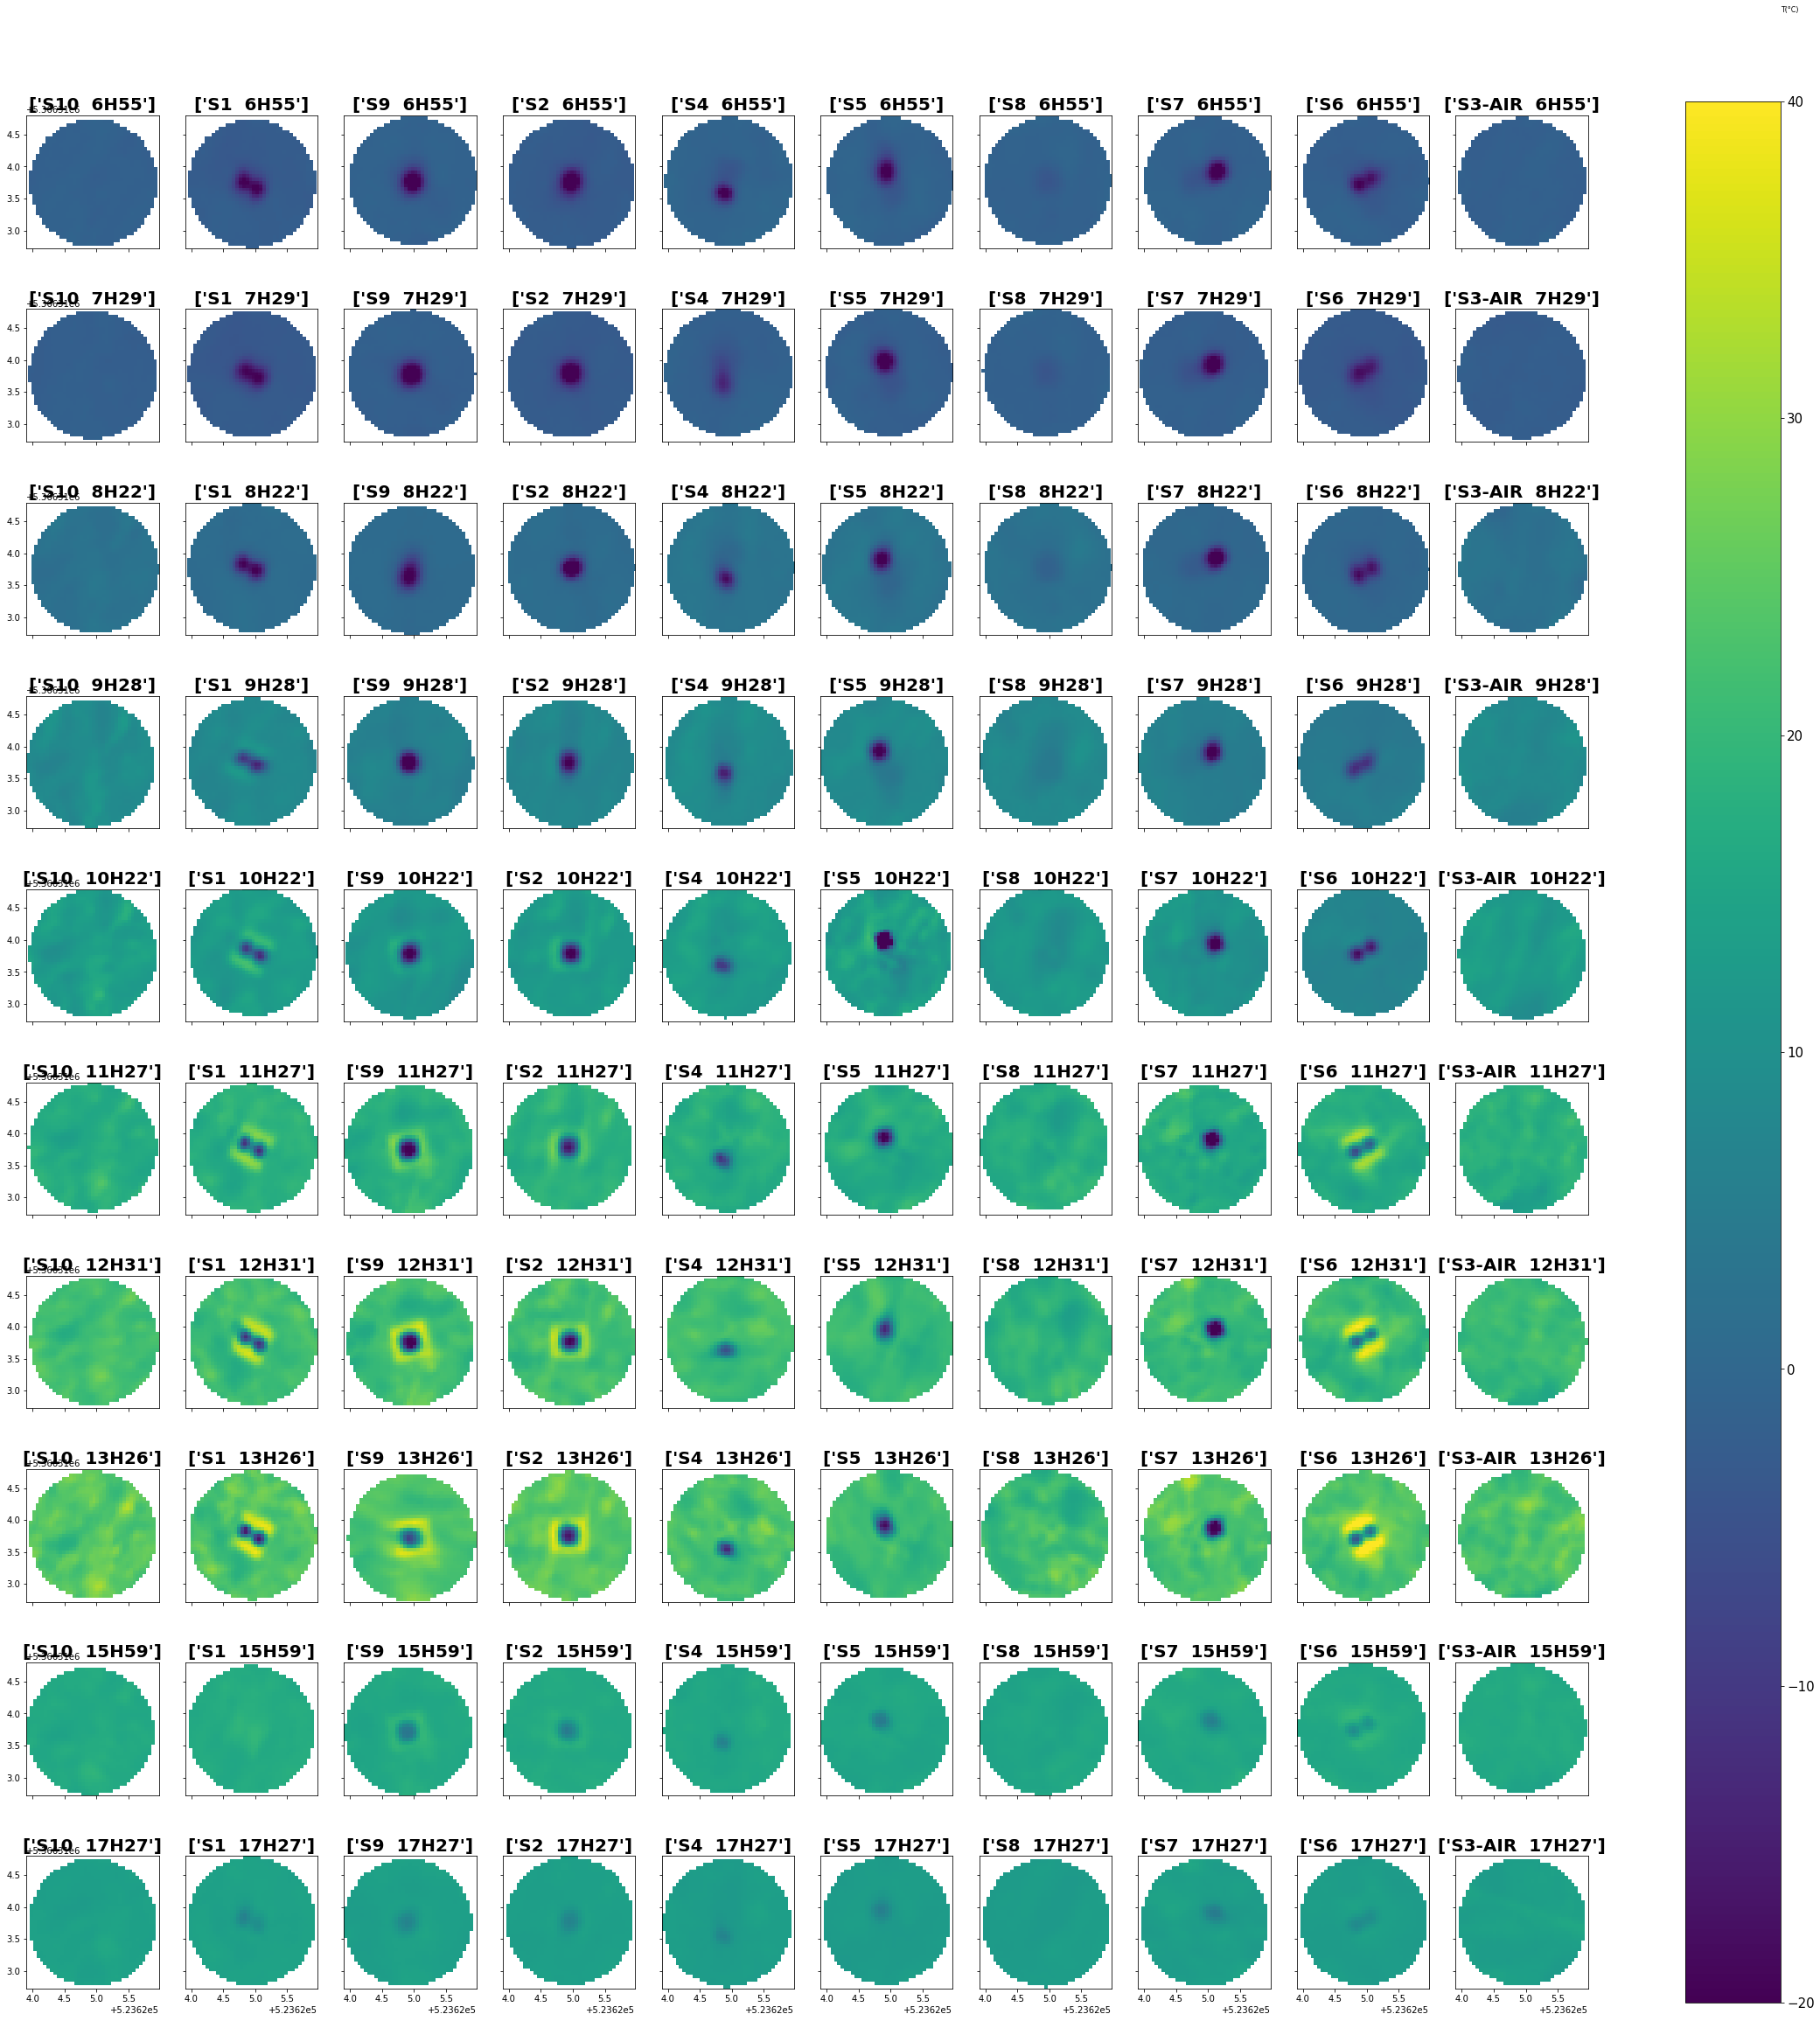

In [6]:
## plot toutes les sondes pour ttes IR, avec une echelle defini par l'utilisateur
lim_min = -20
lim_max = 40
fig_IR,axtemp=plt.subplots(10,10,figsize=(40,40),sharex=True, sharey=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

for i in range(len(Piren_IR.loc["IR_src"])) :
    for k,mask_image in enumerate(ls_mask_image[i]) :
        sub_fig = axtemp[i,k].imshow(mask_image[0],cmap ='viridis',vmin = lim_min,vmax = lim_max)
        sub =show(mask_image, transform= ls_out_transform[i],vmin = lim_min,vmax = lim_max,
            ax=axtemp[i,k],title=[circle_name[k][k]+'  '+filetif[i]])

sub_fig_colorbar=fig_IR.colorbar(sub_fig,ax = axtemp[0:10])
sub_fig_colorbar.set_label('T(°C)', rotation=0, labelpad=-28, y=1.05)

#### PLOT d'une image IR 

In [7]:
for IR in Piren_IR :
        print(IR)

IR_6H55
IR_7H29
IR_8H22
IR_9H28
IR_10H22
IR_11H27
IR_12H31
IR_13H26
IR_15H59
IR_17H27


## echantillon de sonde / IR

nombre de shapes 10


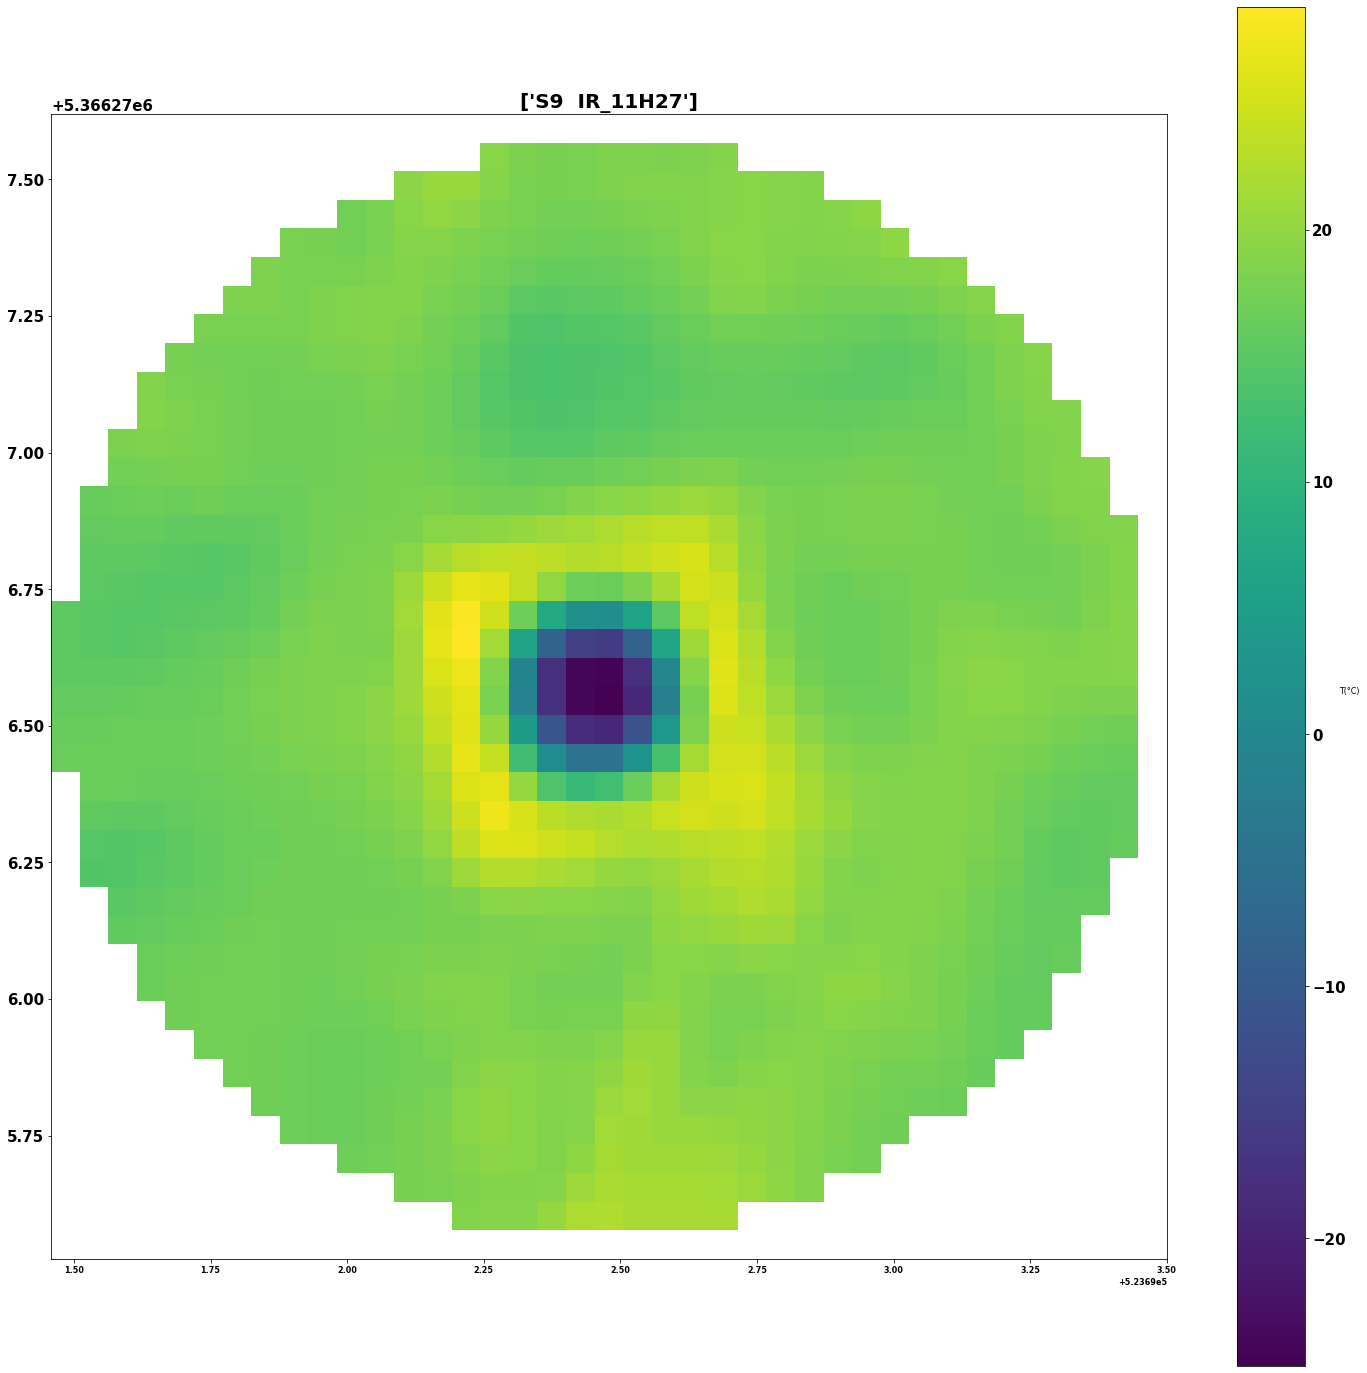

In [118]:
#Methode pour discriminer des IRs

request_IR = ['IR_11H27']
request_sensor = ["S9"]
requested_IR = Piren_IR[request_IR]


## creation d'un rayon de taille r autour des sensors
ls_sensor = Sensor_coord["SensorName"] # : toutes les sondes
ls_coord_circle,Shape_to_json,circle_name = circle_sensor(ls_sensor,Sensor_coord)

#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape

shapes,shapes_names = circle_to_shape(ls_coord_circle,Shape_to_json,circle_name)

requested_names  =  []
requested_shapes =  []
requested_ls_coord_circle = []
for i,names in enumerate(shapes_names) :
    for k in range(len(request_sensor)) :  
        if names == request_sensor[k] :
            requested_names.append(names)
            requested_shapes.append(shapes[i])
            requested_ls_coord_circle.append(ls_coord_circle[i])
            
## Creation de mask pour plusieurs images IR
requested_ls_mask_image, requested_ls_out_transform= IR_mask(requested_IR.loc["IR_src"],requested_shapes,requested_ls_coord_circle)
#Methode pour discriminer des sondes

## Plot d'un echantillon i = IR , k = Sondes
lim_min = -10
lim_max = 20
len_IR = len(requested_ls_mask_image)
len_shapes = len(requested_shapes)
step = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


if len_IR == 1 and len_shapes == 1 : 
    
    fig_IR,axtemp=plt.subplots(1,figsize=(25,25))
    
    for i in range(len_IR) :
        for k,mask_image in enumerate(requested_ls_mask_image[i]) :
            sub_fig = axtemp.imshow(mask_image[0],cmap ='viridis')#,vmin = lim_min,vmax = lim_max)
            sub =show(mask_image, transform= requested_ls_out_transform[i],
                ax=axtemp,title=[requested_names[k]+'  '+request_IR[i]])#,vmin = lim_min,vmax = lim_max)

            sub_fig_colorbar=fig_IR.colorbar(sub_fig,ax = axtemp)
            sub_fig_colorbar.set_label('T(°C)', rotation=0)
else :
        
        fig_IR,axtemp=plt.subplots(len_IR,len_shapes,figsize=(25,25))

        for i in range(len_IR) :
            for k,mask_image in enumerate(requested_ls_mask_image[i]) :
                sub_fig = axtemp[i,k].imshow(mask_image[0],cmap ='viridis')#,vmin = lim_min,vmax = lim_max)
                sub =show(mask_image, transform= requested_ls_out_transform[i],
                    ax=axtemp[i,k],title=[requested_names[k]+'  '+request_IR[i]])#,vmin = lim_min,vmax = lim_max)

                sub_fig_colorbar=fig_IR.colorbar(sub_fig,ax = axtemp[i,k])
                sub_fig_colorbar.set_label('T(°C)', rotation=0)

## Comparaison avec les données de la sondes la plus shallow (5cm) a +/-1 h 

In [12]:
### A MODIFIER 
date_1='2019-04-10 12:30:00'
date_2='2019-04-10 14:30:00'


In [13]:
### Crée des Tableaux pour chaque sonde selon leur nom : RawS1,RawS2,..
### Et un dictionnaire associee

ls_path = path_sonde()
name_SONDE =[]
name_SONDE=name_sonde(ls_path,name_SONDE)
dict_sonde = {}
for i,ls_path_sonde in enumerate(ls_path):
    locals()['Raw%s' % name_SONDE[i]] = readingtemp(ls_path_sonde[0])
    dict_sonde[name_SONDE[i]] = ['Raw%s' % name_SONDE[i]]

for name_SONDE in dict_sonde:
    locals()['slice%s' % name_SONDE] = slice_raw(locals()     [dict_sonde[name_SONDE][0]],date_1,date_2)
    print(['slice%s' % name_SONDE])
    


['sliceS1']
['sliceS10']
['sliceS2']
['sliceS3AIR']
['sliceS4']
['sliceS5']
['sliceS6']
['sliceS7']
['sliceS8']
['sliceS9']


nombre de shapes 10


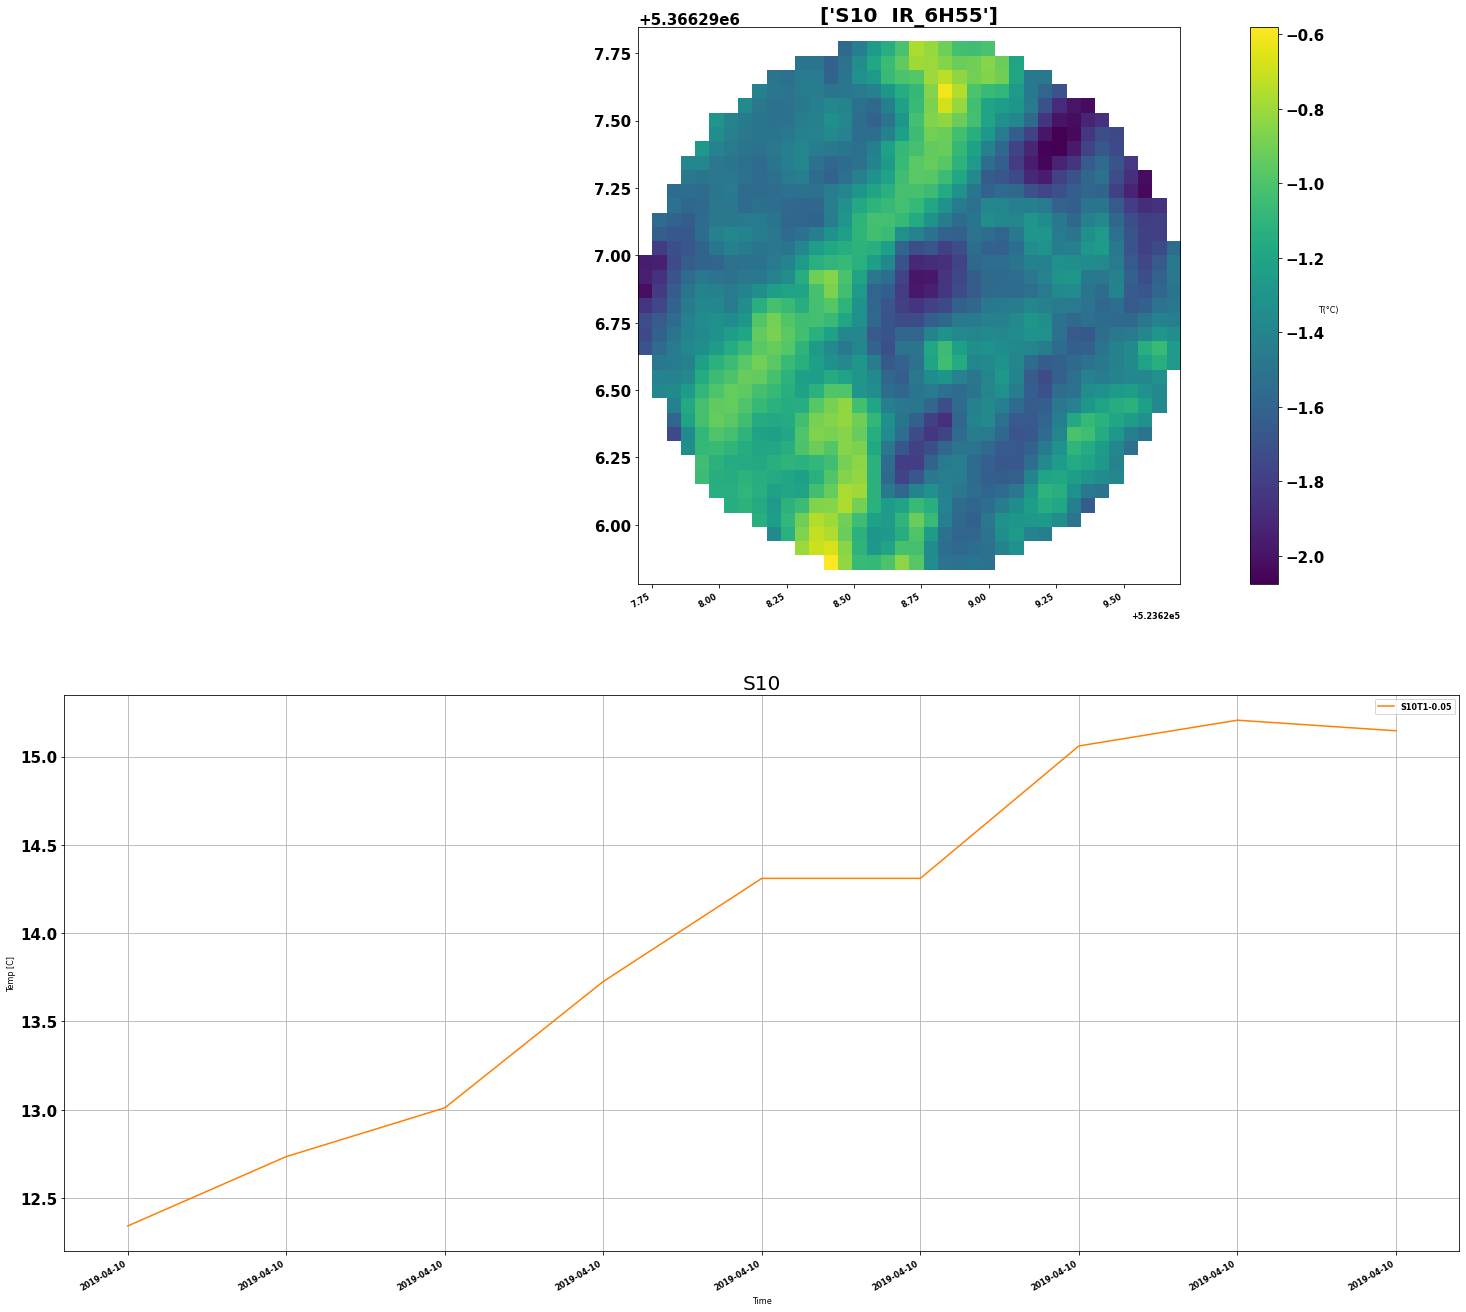

In [14]:
#Methode pour discriminer des IRs

request_IR = ['IR_6H55']
request_sensor = ["S10"]
SLICE = sliceS10  ## à remplacer 

requested_IR = Piren_IR[request_IR]
## creation d'un rayon de taille r autour des sensors
ls_sensor = Sensor_coord["SensorName"] # : toutes les sondes
ls_coord_circle,Shape_to_json,circle_name = circle_sensor(ls_sensor,Sensor_coord)

#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape
shapes,shapes_names = circle_to_shape(ls_coord_circle,Shape_to_json,circle_name)


requested_names  =  []
requested_shapes =  []
requested_ls_coord_circle = []
for i,names in enumerate(shapes_names) :
    for k in range(len(request_sensor)) :  
        if names == request_sensor[k] :
            requested_names.append(names)
            requested_shapes.append(shapes[i])
            requested_ls_coord_circle.append(ls_coord_circle[i])
            
## Creation de mask pour plusieurs images IR
requested_ls_mask_image, requested_ls_out_transform= IR_mask(requested_IR.loc["IR_src"],requested_shapes,requested_ls_coord_circle)
#Methode pour discriminer des sondes

## Plot d'un echantillon i = IR , k = Sondes
lim_min = -10
lim_max = 20
len_IR = len(requested_ls_mask_image)
len_shapes = len(requested_shapes)
step = 1

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 28 }

plt.rc('font', **font)



fig_IR,axtemp=plt.subplots(2,1,figsize=(25,25))

for i in range(len_IR) :
    for k,mask_image in enumerate(requested_ls_mask_image[i]) :
        sub_fig = axtemp[0].imshow(mask_image[0],cmap ='viridis')#,vmin = lim_min,vmax = lim_max)
        sub =show(mask_image, transform= requested_ls_out_transform[i],
            ax=axtemp[0],title=[requested_names[k]+'  '+request_IR[i]])#,vmin = lim_min,vmax = lim_max)

        sub_fig_colorbar=fig_IR.colorbar(sub_fig,ax = axtemp[0])
        sub_fig_colorbar.set_label('T(°C)', rotation=0)

plottingtemp_single_label_IR(SLICE,fig_IR,axtemp[1],'T4',step)

In [144]:
whos

Variable                 Type           Data/Info
-------------------------------------------------
IR_mask                  function       <function IR_mask at 0x000001AABF834C10>
Piren_IR                 DataFrame                               <...>./traitement_PIREN/0...  
Piren_IR_ls              list           n=10
Point                    type           <class 'shapely.geometry.point.Point'>
Sensor_coord             DataFrame        SensorName           x <...>  523624.949  5366313.764
Shape_to_json            list           n=3
ax_IR                    AxesSubplot    AxesSubplot(0.142838,0.125;0.602162x0.755)
ax_cm                    AxesSubplot    AxesSubplot(0.125,0.125;0.62x0.755)
axrgb                    ndarray        10: 10 elems, type `object`, 80 bytes
axtemp                   ndarray        10: 10 elems, type `object`, 80 bytes
cax                      Axes           Axes(0.85,0.1;0.075x0.8)
circle_name              list           n=3
circle_sensor            function  

## ANNEXE

In [ ]:
#Methode pour discriminer des IRs

request_IR = ['IR_11H27',"IR_12H31"]
request_sensor = ["S9","S2","S4"]
requested_IR = Piren_IR[request_IR]

## Creation de mask pour plusieurs images IR
requested_ls_mask_image, requested_ls_out_transform= IR_mask(requested_IR.loc["IR_src"],requested_shapes,requested_ls_coord_circle)
#Methode pour discriminer des sondes

## creation d'un rayon de taille r autour des sensors
ls_sensor = Sensor_coord["SensorName"] # : toutes les sondes
ls_coord_circle,Shape_to_json,circle_name = circle_sensor(ls_sensor,Sensor_coord)

#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape

shapes,shapes_names = circle_to_shape(ls_coord_circle,Shape_to_json,circle_name)

requested_names  =  []
requested_shapes =  []
requested_ls_coord_circle = []
for i,names in enumerate(shapes_names) :
    for k in range(len(request_sensor)) :  
        if names == request_sensor[k] :
            requested_names.append(names)
            requested_shapes.append(shapes[i])
            requested_ls_coord_circle.append(ls_coord_circle[i])
            
requested_names
requested_shapes
len(requested_ls_coord_circle)

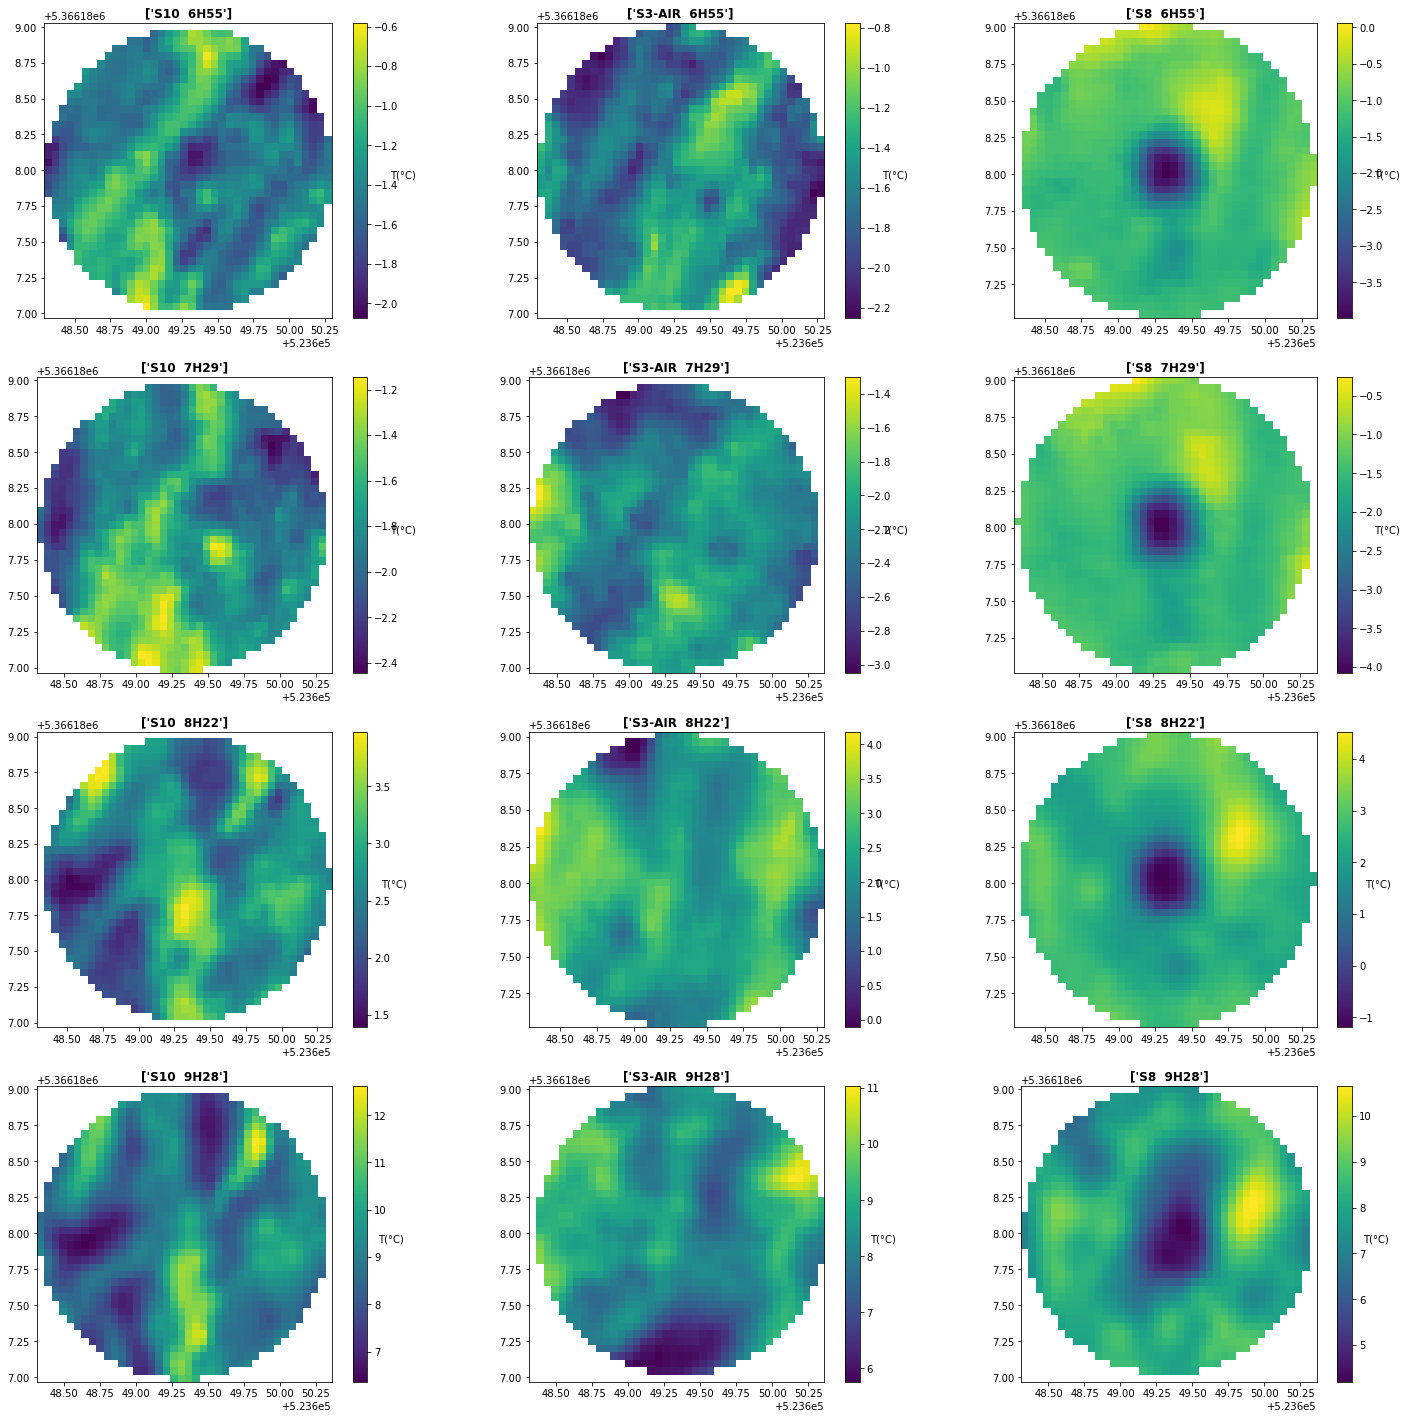

In [269]:
## 1e moitié des sondes IR, avec une echelle defini par l'utilisateur
lim_min = -10
lim_max = 20
lim_tif = len(Piren_IR.loc["IR_src"])
lim_tif = 4
fig_IR,axtemp=plt.subplots(lim_tif,len(ls_sensor),figsize=(25,25))
for i in range(lim_tif) :
    for k,mask_image in enumerate(ls_mask_image[i]) :
        sub_fig = axtemp[i,k].imshow(mask_image[0],cmap ='viridis')#,vmin = lim_min,vmax = lim_max)
        sub =show(mask_image, transform= ls_out_transform[i],
            ax=axtemp[i,k],title=[ls_sensor[k]+'  '+filetif[i]])#,vmin = lim_min,vmax = lim_max)

        sub_fig_colorbar=fig_IR.colorbar(sub_fig,ax = axtemp[i,k])
        sub_fig_colorbar.set_label('T(°C)', rotation=0)

In [ ]:
## Chercher si une variable existe ou pas
try: 
    A
except NameError:
        A = 'AHA'
print(A)

In [49]:
## Discrimination des IRs
Piren_IR[request].loc["IR_src"]
len(ls_mask_image_requested)

2

In [9]:
for i in range(len(Piren_IR.loc["IR_src"])):
    print(Piren_IR.loc["IR_src"][i])
print("nombre d'image IR :",len(Piren_IR.loc["IR_src"]))
               

<open DatasetReader name='./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/002_7H29_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/003_8H22_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/004_9H28_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/005_10H22_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/006_11H27_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/007_12H31_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/008_13H26_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/009_15H59_ortho_UTM31N_IR.tif' mode='r'>
<open DatasetReader name='./traitement_PIREN/010_17H27_ortho_UTM31N_IR.tif' mode='r'>
nombre d'image IR : 10


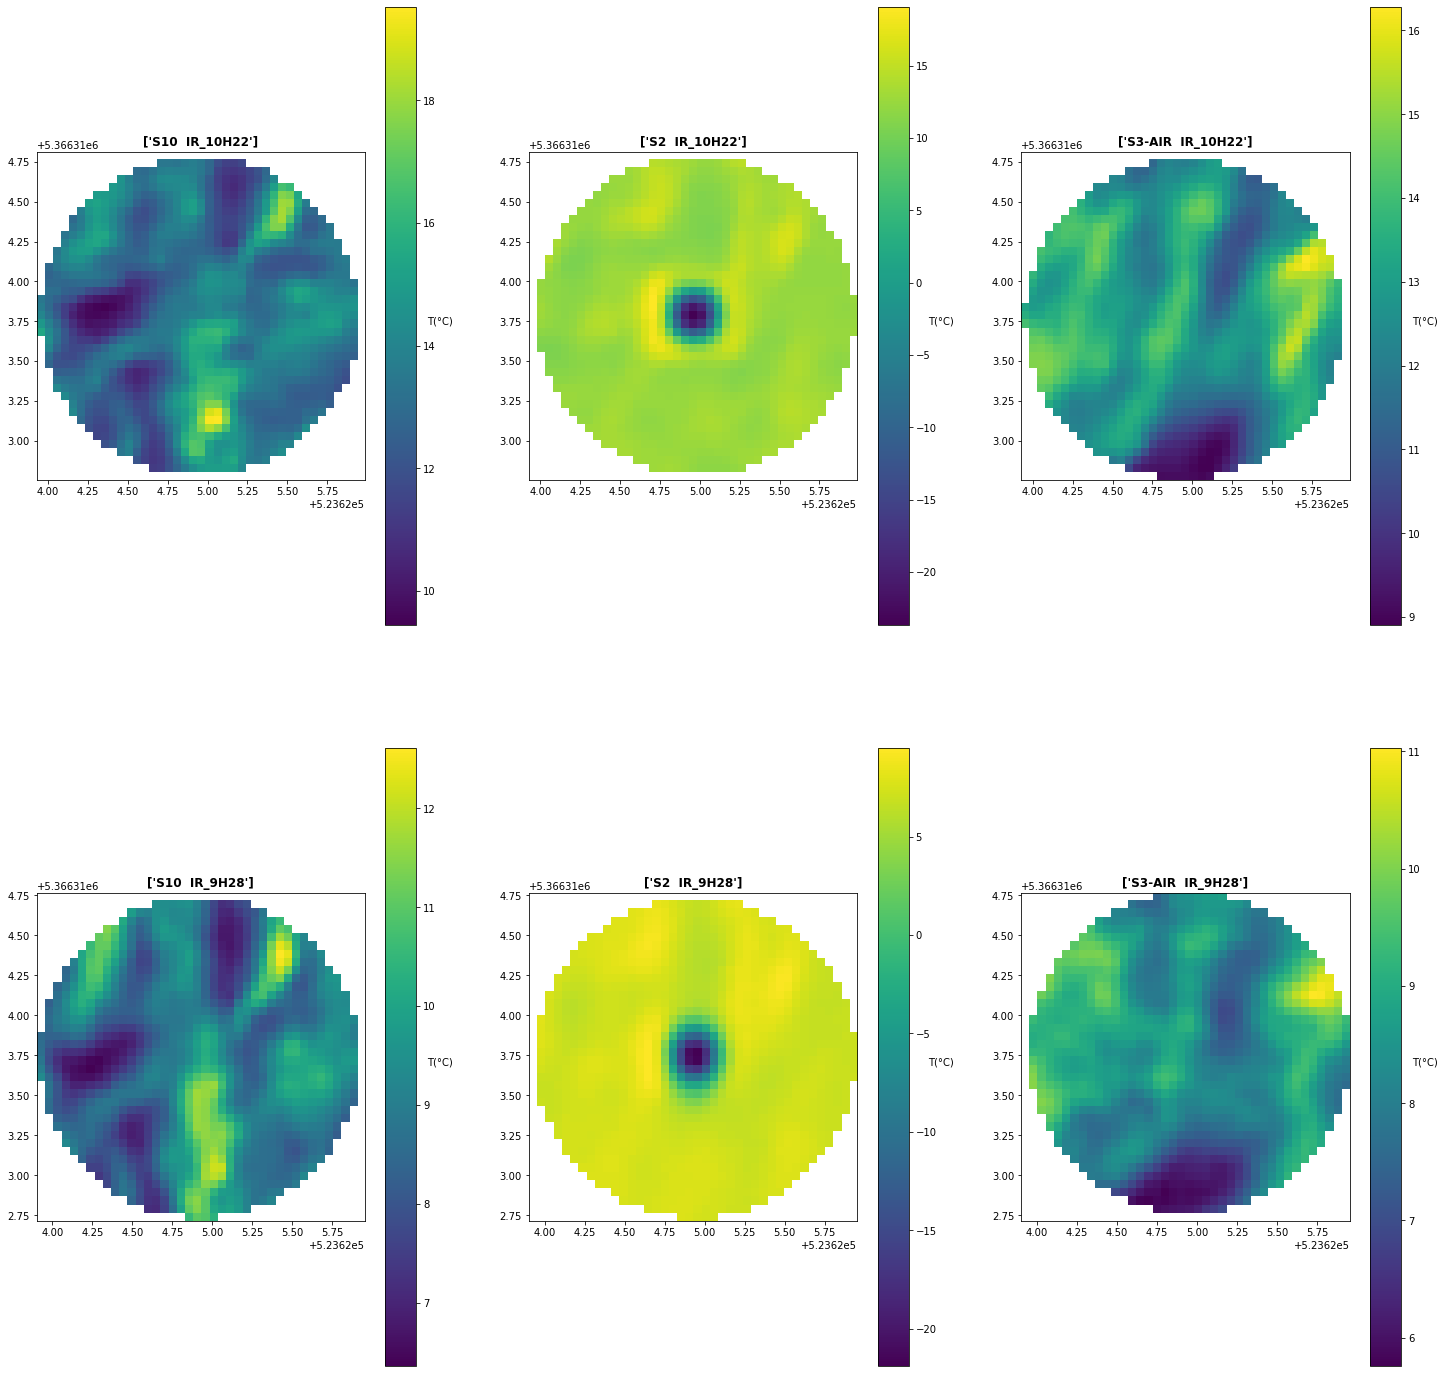

In [55]:
## 1e moitié des sondes IR, avec une echelle defini par l'utilisateur
lim_min = -10
lim_max = 20
len_IR = len(requested_IR)
len_sondes =
fig_IR,axtemp=plt.subplots(lim_tif,len(ls_sensor),figsize=(25,25))
for i in range(lim_tif) :
    for k,mask_image in enumerate(ls_mask_image[i]) :
        sub_fig = axtemp[i,k].imshow(mask_image[0],cmap ='viridis')#,vmin = lim_min,vmax = lim_max)
        sub =show(mask_image, transform= ls_out_transform[i],
            ax=axtemp[i,k],title=[ls_sensor[k]+'  '+filetif[i]])#,vmin = lim_min,vmax = lim_max)

        sub_fig_colorbar=fig_IR.colorbar(sub_fig,ax = axtemp[i,k])
        sub_fig_colorbar.set_label('T(°C)', rotation=0)

In [ ]:
## plot de tous les histogram autours des sondes 

fig2,(axhist)=plt.subplots(9,figsize=(10,30),sharex=True, sharey=True)
for k,mask_image in enumerate(ls_mask_image) :
    show_hist(mask_image, bins=50, histtype='stepfilled', lw=0.0, stacked=False, ax=axhist[k], alpha=0.3, title=circle_name[k][k])


In [ ]:
## Plot de chaque couple histo/image

for k,mask_image in enumerate(ls_mask_image) :
    fig2,(axhist,axrgb)=plt.subplots(1,2,figsize=(50,50))
    show_hist(mask_image, bins=50, histtype='stepfilled', lw=0.0, stacked=False, ax=axhist, alpha=0.3, title=circle_name[k][k])
    show(mask_image, transform=ls_out_transform,ax=axrgb,title=circle_name[k][k])
    #plt.plot(np.array(Sensor_coord["x"][k]),np.array(Sensor_coord["y"][k]),'bo')

In [ ]:
for k in range(1,len(Piren_IR_ls)) :
    Piren_IR.assign(locals()[IR_%s % Piren_IR_name[1][k]] = Piren_IR_ls[k])

In [ ]:
for k in range(1,len(filetif)) :
    locals()['SS_%s' % filetif[k]] = 1
    print(locals()['SS_%s' % filetif[k]])

locals()['SS_%s' % filetif[1]]

In [ ]:
out_meta = IR_src.meta
for k in range(len(list_coord_circle)) :
    out_image, out_transform = rio.mask.mask(IR_src, shapes[k], crop=True, filled=False)
    """
    And update height and width of cropped image with its meta data"""
    out_meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform})
    
    fig2,(axhist, axrgb)=plt.subplots(1,2, figsize=(21,7))
    show(out_image, transform=out_transform,ax=axrgb)
    #plt.plot(np.array(Sensor_coord["x"][k]),np.array(Sensor_coord["y"][k]),'bo')
    show_hist(out_image, bins=50, histtype='stepfilled', lw=0.0, stacked=False, ax=axhist, alpha=0.3, title=circle_name[k][k])

In [ ]:
out_meta = IR_src.meta
out_image, out_transform = rio.mask.mask(IR_src, shapes[0], crop=True, filled=False)
"""
And update height and width of cropped image with its meta data"""
out_meta.update({"driver": "GTiff",
         "height": out_image.shape[1],
         "width": out_image.shape[2],
         "transform": out_transform})

show(out_image, transform=out_transform)

In [ ]:
#Rasterio 
IR_src = rio.open(os.path.join(ls_path_tif[0]))
#show((src,1)) # Affiche la premiere bande
#fig1,ax1 = show((src,1),cmap='viridis')
Piren_IR_array=IR_src.read(1) # Lit la bande 1
Piren_Limits = plotting_extent(IR_src) # Limites
Piren_Limits
Piren_res = IR_src.res # resolution
Piren_res
fig_IR,ax_IR=plt.subplots(1,figsize=(50,50))
sub_fig=ax_IR.imshow(Piren_IR_array,extent=Piren_Limits,cmap='viridis')
ax_IR.set_xlabel('x')
ax_IR.set_ylabel('y')
ax_IR.set_label(ls_path_tif[0])
sub_fig_colorbar=fig_IR.colorbar(sub_fig)
sub_fig_colorbar.set_label('T(°C)', rotation=0, labelpad=-28, y=1.05)

## Plot des coordonnees de la sonde
#plt.plot(np.array(Sensor_coord["x"]),np.array(Sensor_coord["y"]),'bo')
## Plot des coordonnees de la sonde
#ax_IR.annotate(str(sensor_GPS["SensorName"]),[np.array(Sensor_coord["x"]),np.array(Sensor_coord["y"])])

In [ ]:
Piren_IR_test = pd.DataFrame(np.array([Piren_IR[0][0],Piren_IR[0][1],Piren_IR[0][2]],dtype=object).T,index =
                            ["IR_array","Limits","IR_src"],columns = ['001'])
Piren_IR_test['001']['IR_array']

In [ ]:
sss = np.array([Piren_IR_array,Piren_Limits,IR_src],dtype=object).T
sss.shape

In [ ]:
#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape
shapes = []
for j in range(len(list_coord_circle)):
    with fiona.open(Shape_to_json[j],'r') as Test_image:
        #print(list(Test_image)) # On va chercher à chopper la propriete Geometry
        shapes.append([feature["geometry"] for feature in Test_image])
print(len(shapes))

In [ ]:
len_coord = len(Sensor_coord)
value = []
for k in range(0,len_coord) :
    for val in IR_src.sample([(float(Sensor_coord["x"][k]),float(Sensor_coord["y"][k]))]): 
        value.append(val)
    coord_value = np.array([Sensor_coord["x"],Sensor_coord["y"],value])
coord_value.shape

In [ ]:
Piren_IR_array.shape
IR_src.tags
aaa = rio.sample.sample_gen(IR_src,([523628.71,5366296.81]),indexes=None,masked=False)
for val in IR_src.sample([(float(Sensor_coord["x"][0]),float(Sensor_coord["y"][0]))]): 
    print(val)

In [ ]:
#Recupere les noms des IR dans le dossier path, 
#par defaut = './traitement_PIREN/'
ls_path_tif = path_IR()
ls_path_tif[0][0]
for test_tif in ls_path_tif:
    print(test_tif[0],type(test_tif[0]))
    if test_tif[0].find('003') > 0:
        aaa = test_tif[0]
        break
aaa

In [7]:
# Ouverture et recupération des positions de Sensors 
Sensor_Name_File_GPS=[]
Sensor_x=[]
Sensor_y=[]
k = 0
with open("./traitement_PIREN/sondes_gps_UTM31N_phase1.txt") as File_GPS:
    csvReader=csv.reader(File_GPS, delimiter='\t')
    for row in csvReader:
        Sensor_Name_File_GPS.append(row[0]) ## colonne nom du fichier
        # str list to float list, for plot option
        Sensor_x.append(float(row[1])) # colonne coordonnees x 
        Sensor_y.append(float(row[2])) # colonne coordonnees y
        print("x =",Sensor_x[k],'  y =',Sensor_y[k])
        k+=1

x = 523628.71   y = 5366296.81
x = 523654.74   y = 5366287.75
x = 523692.47   y = 5366276.57
x = 523660.22   y = 5366258.91
x = 523636.075   y = 5366245.545
x = 523641.825   y = 5366220.67
x = 523649.33   y = 5366188.02
x = 523696.655   y = 5366174.0
x = 523694.05   y = 5366209.93


In [5]:
### Recupere les noms des Sensors dans le dossier path, par defaut = './Data/'
path = './traitement_PIREN/'
ls_path_tif = []
ls_path = os.listdir(path=path)
for tif in ls_path:
    if tif.find('.tif') > 0 :
        ls_path_tif.append([path+tif])

[['./traitement_PIREN/.ipynb_checkpoints']]
[['./traitement_PIREN/.ipynb_checkpoints'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR']]
[['./traitement_PIREN/.ipynb_checkpoints'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif']]
[['./traitement_PIREN/.ipynb_checkpoints'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif'], ['./traitement_PIREN/002_7H29_ortho_UTM31N_IR']]
[['./traitement_PIREN/.ipynb_checkpoints'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif'], ['./traitement_PIREN/002_7H29_ortho_UTM31N_IR'], ['./traitement_PIREN/002_7H29_ortho_UTM31N_IR.tif']]
[['./traitement_PIREN/.ipynb_checkpoints'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR'], ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif'], ['./traitement_PIREN/002_7H29_ortho_UTM31N_IR'], ['./traitement_PIREN/002_7H29_ortho_UTM31N_IR.tif'], ['./traitement_PIREN/003_8

In [23]:
Sensor_coord =pd.DataFrame(np.array([Sensor_Name_File_GPS,Sensor_x,Sensor_y]).T)
Sensor_coord

,0,1,2
0,S10,523628.71,5366296.81
1,S1,523654.74,5366287.75
2,S9,523692.47,5366276.57
3,S2,523660.22,5366258.91
4,S4,523636.075,5366245.545
5,S5,523641.825,5366220.67
6,S8,523649.33,5366188.02
7,S7,523696.655,5366174.0
8,S6,523694.05,5366209.93


In [25]:
## creation d'un rayon de taille r autour d une Sensor (S10)
list_coord_circle = []
Shape_to_json=[]
circle_name = []

len_sensor = len(Sensor_coord['SensorName'])
for SensorName in Sensor_coord['SensorName'] :
    sensor_GPS = Sensor_coord.loc[Sensor_coord['SensorName']==str(SensorName)]
    center = Point(sensor_GPS["x"],sensor_GPS["y"])
    circle = center.buffer(1)
    #Val de chaque extremitees du cercle
    x_circle,y_circle = circle.exterior.xy
    list_coord_circle.append([np.array(x_circle),np.array(y_circle)])
    # Transfo des donnees en Geoseries : 
    #Json -> https://fr.wikipedia.org/wiki/JavaScript_Object_Notation
    # Format qui contient toutes les proprietes + points ext du cercle
    Shape_to_json.append(gpd.GeoSeries([circle]).to_json())
    circle_name.append(sensor_GPS['SensorName'])
    list_coord_circle

[[array([523629.71      , 523629.70518473, 523629.69078528, 523629.66694034,
         523629.63387953, 523629.59192126, 523629.54146961, 523629.48301045,
         523629.41710678, 523629.34439328, 523629.26557023, 523629.18139674,
         523629.09268343, 523629.00028468, 523628.90509032, 523628.80801714,
         523628.71      , 523628.61198286, 523628.51490968, 523628.41971532,
         523628.32731657, 523628.23860326, 523628.15442977, 523628.07560672,
         523628.00289322, 523627.93698955, 523627.87853039, 523627.82807874,
         523627.78612047, 523627.75305966, 523627.72921472, 523627.71481527,
         523627.71      , 523627.71481527, 523627.72921472, 523627.75305966,
         523627.78612047, 523627.82807874, 523627.87853039, 523627.93698955,
         523628.00289322, 523628.07560672, 523628.15442977, 523628.23860326,
         523628.32731657, 523628.41971532, 523628.51490968, 523628.61198286,
         523628.71      , 523628.80801714, 523628.90509032, 523629.00028468,

In [41]:
plot_test = gpd.GeoSeries([circle])
plot_test.head()

0    POLYGON ((523629.710 5366296.810, 523629.705 5...
dtype: geometry